Authors: Roberta, Dora, Zigfrid  
dependecies: Python 3.6.4+

# TF IDF Report

## Table of Content 

1. Map Reduce Algorithm: a description of the _adopted solution_

    1a. Other designed algorithms plus related global comments/description including comments to the code 

3. Experimental analysis, concerning in particular scalability 

    2a. Comments about the experimental analysis outlining weak and strong points of the algorithms.

4. an appendix including all the code

# 1. MapReduce algorithm
calculate TF-IDF scores given an input set of documents. Provide both a MapReduce Python Hadoop streaming and a Spark implementation. 
## 1.a. Adopted Version

### Python Hadoop

The first implementation of Tf-Idf is a tradidional MapReduce algorithm, designed to be run on a Hadoop cluster with only Python 2.7/3.+ dependencies. It consists of consecutive Map and Reduce jobs, with the following inputs and outputs:

### Spark

## 1.b. Other designed algorithms

### Python Hadoop

### Spark


# 2. Experimental analysis
compare performances of the two implementation. To test scalability consider 5 document sets of increasing sizes. For instance, size can double from a set to another including  comments about the experimental analysis outlining weak and strong points of the algorithms.

Text source ideas - project guttenberg: https://www.gutenberg.org/
movie transcripts - https://www.imsdb.com/TV/Futurama.html


### Practical Instructions to run tests on the cluster

Collect speed information here: https://docs.google.com/spreadsheets/d/1woubFQECRr-0GMBUtKGj6vq0i8aybqAdAYiR-eaTaOY/edit?usp=sharing

1. Create text
* create input directory on /user/hadoop local file system 
* in /input, wget python script and execute the text_generator function to create documents needed, specify params as described below. if you already created soem files, remember to change the startnr.
* afterwards, move only the .txt to the hdfs hadoop input directory 

2. Download the scripts mapper 1 - reducer 3, and the .bash script
 + give permission to access all documents
 + execute all jobs through bash script runjobs.sh

After one job is done, remove all input and output directories, and create a new input directory on hdfs to be filled with the new text documents.

### Performance of the different algorithms

In [210]:
import pandas as pd
import math 
tests = pd.read_csv('MapReduce_Tests.csv',usecols=[0,1,2,3,4,5])
tests.columns=["Algorithm","time_type","observed_time","NumDocs","NumWordsPerDoc","Test"]


In [216]:
def convert_time(x):
    if isinstance(x, str):
        if "m" in x: 
            minutes, seconds = x.split("m")
        else: 
            minutes = 0
            seconds = x
        seconds = seconds.strip("s")
        total_seconds = float(seconds) + (int(minutes)*60)
        return(total_seconds)


#convert all time into seconds 
tests["Time_seconds"]=tests["observed_time"].apply(convert_time)
#count total number of words per test 
tests["Total_Words"] = tests['NumDocs']*tests['NumWordsPerDoc']


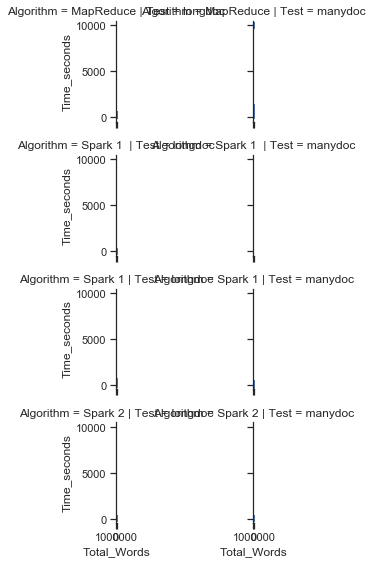

In [217]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline  
plt.rcParams['figure.figsize'] = [20, 20]
sns.set(style="ticks")

mapred = tests[(tests["Algorithm"] == "MapReduce") & (tests["time_type"] != "real") &  (tests["Test"] != "TEST") ]
# modify test type times to compare different times 
allalgs  = tests[ ((tests["time_type"] == "real") | (tests["time_type"] == "time") )& (tests["Test"] != "TEST") ]

grid = sns.FacetGrid(allalgs, col="Test", row="Algorithm", height=2)
grid.map(plt.plot, "Total_Words", "Time_seconds", marker="o")

# 3. Code Appendix

## text_generator.py
*Requirements* Requires installing the nlkt library brown (python -m nltk.downloader brown). 


*Functionality* The function create_docs takes as input parameters the number of words per document, number of documents, and start number of the document to be taken into account when naming files. The function creates the specified number of documents at the specified length by taking samples of the brown corpus. It randomly samples lines of twenty words at the same time.

The Brown University Standard Corpus of Present-Day American English (or just Brown Corpus) was compiled in the 1960s as a general corpus. It contains 500 samples of English-language text, totaling roughly one million words, compiled from works published in the United States in 1961. It is a suitable library to sample from in order to test our algorithm as it represents how language is used in reality. 

In [ ]:
#!/usr/bin/python
from nltk.corpus import brown
import random
corpus_length = len(brown.words())
hardcopy = brown.words()


def create_docs(number_of_words_per_doc=200, num_doc=10, startnr=0):
    # control number of words per doc
    # and number of documents
    # we fix the line length at 20
    line_length = 20
    number_of_lines = int(number_of_words_per_doc / line_length)

    for i in range(0, num_doc):
        # create new file with writing + permission
        new_file = open("textdoc"+str(number_of_words_per_doc) +
                        "words" + str(i+startnr)+".txt", "w+")
        for line in range(0, number_of_lines):
            words = list(map(
                lambda x: hardcopy[x:x+line_length], random.sample(range(corpus_length), line_length)))
            sentences = list(
                map(lambda x: ' '.join(word for word in x), words))
            text = ''.join(map(str, sentences))
            new_file.write(text + "\n")
        new_file.close()
        if (i % 10 == 0):
            print("You created "+str(i)+" files! "+str(num_doc-i)+" left")